In [1]:
import random
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize
%matplotlib inline

##The Logit Function
The logit function is given by $logit(x)=\frac{1}{1+e^{-x}}$. To build up intuition, let's plot logit(x), logit(2x) and logit(x-a) by running the next cell.

###High number instabilities
Python is prone to complain if you ask it to calculate $e^{50}$ for example. Despite the fact that $\frac{1}{1+e^{-50}}$ is very well-defined and essentially equal to unity, calculating logit(50) in this way is prone to math domain errors. For this reason, we have added a truncation for $|x|>30$. For $x<-30$ we return log(-30) and similarly for $x>30$.

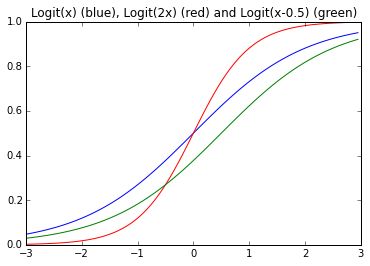

In [12]:
def logit(x):
    #truncate the domain of the function to avoid high number instabilities and math domain errors
    if x>30.:
        return logit(30)
    elif x<-30.:
        return logit(-30)
    return(1./(1+math.exp(-1.*x)))

sample_points=[float(i-60)/20. for i in range(120)]


plt.figure()
plt.title("Logit(x) (blue), Logit(2x) (red) and Logit(x-0.5) (green)")
logit_points=[logit(sample_points[i]) for i in range(len(sample_points))]
plt.plot(sample_points,logit_points,c='b')
logit_points=[logit(2*sample_points[i]) for i in range(len(sample_points))]
plt.plot(sample_points,logit_points,c='r')
logit_points=[logit((sample_points[i]-0.5)) for i in range(len(sample_points))]
plt.plot(sample_points,logit_points,c='g')
plt.show()

As should be evident from the above plot, when we fit a logit function (in one dimension), there are two things we can tune, the steepness and the offset. By offset, it is meant the point at which the logit function=0.5. This is the point of inflection and the decision boundary. The steepness governs how quickly a prediction goes from a "very uncertain" value of 0.5 to values of high certainty. 

Next, let's read in the first set of labelled data and visualise it

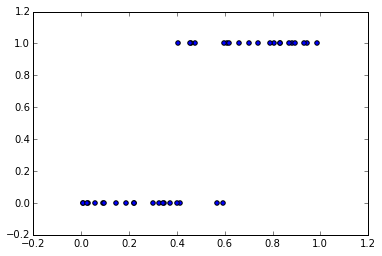

In [8]:
data=np.load("1d_data.npy")
features=[i[0] for i in data]
classifier=[i[1] for i in data]

plt.scatter(features,classifier)
plt.show()

##Separability of the data
It should be evident from the above plot, that in general, points with lower values of x tend to be in the class labelled as "0" and points with higher values of x are likely to be in class 1. Nonetheless, there is a transition region, roughly from x=0.4-0.6 in which the x-value does not tell us the class definitively. Intuitively, one would expect the "best" logit function to be one which is centred roughly at x=0.5 and which is predicting high certainty values for $x<0.4$ and $x>0.6$.


##Maximum Likelihood/Logloss
But how do we calculate this exactly? What is it we are trying to optimise? Given we have to make multiple predictions (one for each data point), the best prediction is one which has assigned the highest probability to the actual outcome. This is a manifestation of the so-called maximum likelihood principle. We are trying to maximise $\Pi_{i}p_{i}$ in which $p_{i}$ is the probability we predicted of the actual classification of each individual training instance. Because however, this might be a product over a potentially very large data set, and each of these probabilities is less than unity, $\Pi_{i}p_{i}$ will more often than not be a very small number (there will be a so-called likelihood attached to every possible outcome, which for a data set with N points and two possible classes means $2^{N}$ different scores which must sum to unity). In order to not run into small number numerical innaccuracy problems, we take the log of the likelihood score which turns the product into a sum $\Sigma _{i}\log(p_{i})$. The log function is monotonic so we are still looking to maximise this score.

For a binary classifier in which we label the classifiers as 1 and 0, if $p_{i}$ represents the probability that data point i belongs to class 1, we can express this as $\Sigma _{i} \left(p_{i}\log (p_{i}) + (1-p_{i})\log(1-p_{i})\right)$

$p_{i}=logit(x_{i};\theta)$ in which $x_{i}$ are the features and $\theta$ is the set of parameters that must be optimised. The rest of this notebook will be to do with examining various sets of toy training data, deciding what parameters it makes sense to include by way of visualising the data and then optimising them to maximise our log-likelihood (or logloss) score

##Parameter optimisation in 1d
For the first data set, we need to optimise two parameters, the offset and the steepness. This will determine where the decision boundary is, as well as how far from the decision boundary one must be in order to get predictions with a high certainty. The function below calculates the log likelihood score for a set of data with 1 feature using a logit function with these two properties as a predictor (for a binary classifier)

In [10]:
def one_d_logloss(data,label,steepness,offset):
    log_sum=0
    if(len(label)!=len(data)):
        print "Features and Labels have different lengths and cannot correspond"
        return
    
    for i in range(len(data)):
        if label[i]==1:
            #taking the log base 10 but other logs are valid
            log_sum+=math.log(logit(steepness*(data[i]-offset)),10)
        else:
            log_sum+=math.log((1-logit(steepness*(data[i]-offset))),10)
    return(log_sum)

#in order to use scipy's minimise method, we'll need a wrapper function. We return -1* logloss because we are going to use
#scipy's minimise function but we want to maximise logloss

def one_d_wrapper(parameters):
    return -1*one_d_logloss(features,classifier,parameters[0],parameters[1])


            
    
    

Now we are ready to run scipy's minimise. The logit function is chosen because even in the limit $x \to \infty$, logit(x) remains finite. Note that because we have truncated the logit function's domain at $|x|\leq 30$, this can lead to scipy complaining about loss of accuracy, but we know that this will be minimal.

In [13]:
#the only compulsory argument for scipy's minimize function is an initial starting guess for the parameters. More details
#for optional arguments to bound the search or use a different method can be found here: http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html
minimisation_result=minimize(one_d_wrapper,[0,0])

minimisation_result

   status: 0
  success: True
     njev: 16
     nfev: 64
 hess_inv: array([[  5.42102205e+01,  -4.60969614e-02],
       [ -4.60969614e-02,   4.09954072e-03]])
      fun: 3.9497211221116513
        x: array([ 14.26400982,   0.47417013])
  message: 'Optimization terminated successfully.'
      jac: array([  8.94069672e-08,  -4.76837158e-07])

The output might vary slightly when you run it on your machine, but the parameter values should give you a classifier which looks roughly like
$\frac{1}{1+e^{-14.264\left(x-0.474\right)}}$

Let's plot the exact result and overlay it on the data

In [37]:
steepness=minimisation_result['x'][0]
offset=minimisation_result['x'][1]

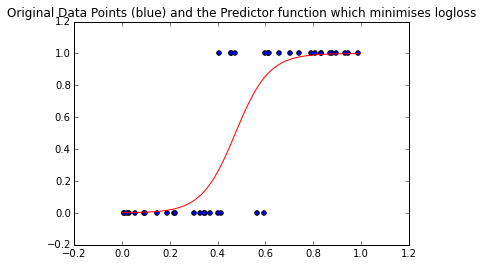

In [39]:
x_axis=[float(i)/100. for i in range(100)]
predictor=[logit(steepness*(x_axis[i]-offset)) for i in range(len(x_axis))]
plt.figure()
plt.title("Original Data Points (blue) and the Predictor function which minimises logloss")
plt.scatter(features,classifier,c='b')
plt.plot(x_axis,predictor,c='r')
plt.show()

The rest of this notebook will essentially involve carrying out this same process for different data sets. 

##2d Data
Read the followng data in and visualise it

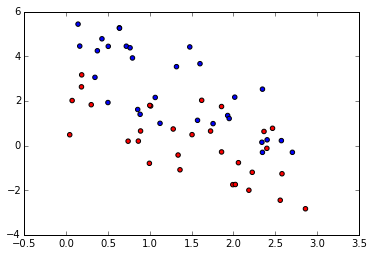

In [23]:
data=np.load("2d_data_linear.npy")
x=[i[0] for i in data]
y=[i[1] for i in data]
classifier=[i[2] for i in data]

plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()

Looking at the above plot, we see that it looks as if, but for noise, there is a linear decision boundary which separates the red and the blue classes (labelled as 1 and 0 respectively). How do we fit a logit function to this? Firstly, this is now a logit function in two variables. Let us assume that our decision boundary is given by the line $y=ax+b$ with a and b to be determined. If $y > ax+b$, then we are "above" the decision boundary and would expect to be within the blue region (especially if $y\gg ax+b$) and similarly if $y \ll ax+b$, we would expect to be within the red region. In essence, we want a logit function which gives us 0.5 if $y=ax+b$, and then becomes more and more certain of which class we are in, the further from the line we are. 

In 1 dimension, we tuned the steepness and the offset. The offset was the point on the x axis at which we were completely uncertain of which class we were in. The corresponding concept in 2d is the line $y=ax+b$, meaning while we had to tune the offset in 1d, we now have to tune $(a,b)$. Similarly, the steepness must be tuned as before. Thus we define our predictor function to take the form $\frac{1}{1+e^{-\gamma \left(y-ax-b\right)}}$ and set out to maximise logloss for our data set

In [15]:
def linear_logloss_2d(steepness,gradient,intercept,x_feature,y_feature,label):
    logloss=0
    if(len(x_feature)!=len(y_feature)):
        print "Features cannot describe same data, length mismatch"
        return
    if(len(x_feature)!=len(label)):
        print "Features cannot describe classifier, length mismatch"
        return
    for i in range(len(x_feature)):
        if label[i]==1:
            logloss+=math.log(logit(steepness*(y_feature[i]-gradient*x_feature[i]-intercept)),10)
        else:
            logloss+=math.log(1-logit(steepness*(y_feature[i]-gradient*x_feature[i]-intercept)),10)
    return(logloss)
def linear_logloss_2d_wrapper(parameters):
    return -1*linear_logloss_2d(parameters[0],parameters[1],parameters[2],x,y,classifier)

minimisation_result=minimize(linear_logloss_2d_wrapper,[0,0,0])

print "Decision Boundary Line: y=%fx+%f"%(minimisation_result['x'][1],minimisation_result['x'][2])

Decision Boundary Line: y=-1.248455x+3.058754


Firstly, let us examine the shape of the decision boundary. 

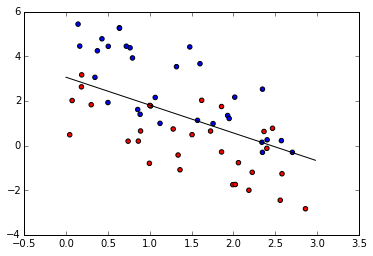

In [52]:
x_axis=[float(i)/50. for i in range(150)]
dec_boundary=[minimisation_result['x'][1]*x_axis[i] +minimisation_result['x'][2] for i in range(len(x_axis))]

plt.figure()
plt.plot(x_axis,dec_boundary,c='k')
plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()


The process of minimising logloss while imposing a linear decision boundary has implemented a sensible linear decision boundary which would have low classification error on the training data. Note that strictly speaking, to do this properly, it would be necessary to perform multiple train-test splits. The current data was generated using $y=-x+3$ as a decision boundary (while adding pseudo random noise) and thus this has actually resulted in over fitting.

Let's finally visualise the 3d logit function

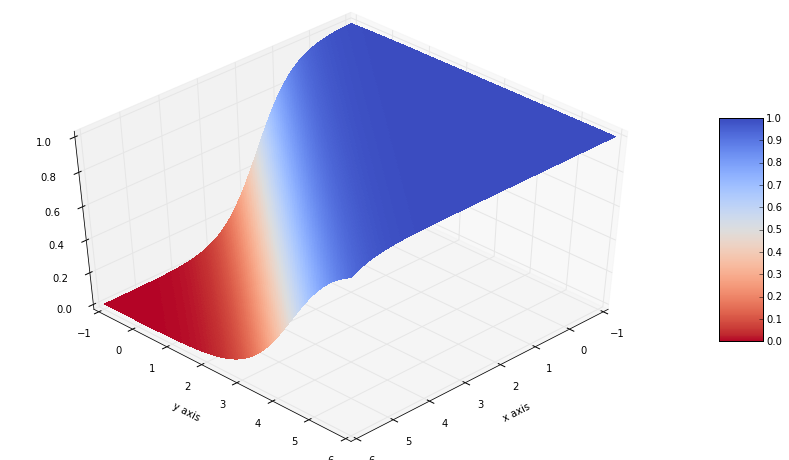

In [25]:
steepness=minimisation_result['x'][0]
gradient=minimisation_result['x'][1]
intercept=minimisation_result['x'][2]

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')

X = np.arange(-1, 6,0.02)
Y = np.arange(-1, 6,0.02)
X, Y = np.meshgrid(X, Y)

Z=[[1-logit(steepness*(Y[i][j]+X[i][j]*gradient +intercept )) for j in range(len(X[0]))] for i in range(len(Y[0])) ]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm_r,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.01, 1.01)

ax.set_xlabel("x axis")
ax.set_ylabel("y axis")


fig.colorbar(surf, shrink=0.5, aspect=5)

ax.azim = 45
ax.elev = 45

plt.show()


As Exercises, two more data sets are provided

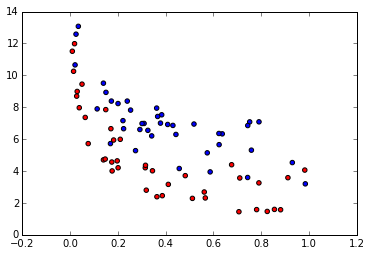

In [66]:
data=np.load("2d_data_reciprocal.npy")
x=[i[0] for i in data]
y=[i[1] for i in data]
classifier=[i[2] for i in data]

plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()


If you attempted to draw a decision boundary in the $(x,y)$ plane, what sort of function would it look like? (there's a hint in the data file name). Use this to define the parameters in your logit function which must then be optimised to maximise logloss.

Remember that if you think the decision boundary should look like $y=f(x;\theta)$, then the function you want to tune looks like $logit(\gamma \left(y-f(x;\theta)\right))$ with $\gamma$ and $\theta$ in need of tuning.

In [ ]:
#add as many parameters as you see fit
def logloss_function_exercise(parameter_1,parameter_2,parameter_3,x_feature,y_feature,label): 
    logloss=0
    for i in range(len(x_feature)):
        if label[i]==1:
            logloss+=math.log(logit(parameter_1*(y_feature[i]- ("Try functions of x here")  )),10)
        else:
            logloss+=math.log(1-logit(parameter_1*(y_feature[i]- ("Put same function here")  )),10)
    return logloss

def logloss_function_exercise_wrapper(parameters):
    return -1*logloss_function_exercise(parameters[0],parameters[1],"etc, depends on how many parameters you've used",x,y,classifier)

#your initial guess vector will need the same number of components as the number of parameters you used

minimisation_result=minimize(logloss_function_exercise_wrapper,[0,0,0]) 


print "The Optimised Steepness is",minimisation_result['x'][0]
print "The decision boundary parameter values are"
for i in range(1,len(minimisation_result['x'])):
    print minimisation_result['x'],i

x_coordinates=[float(i)/100 for i in range(100)]
decision_boundary=[ "your function of x_coordinates[i]" for i in range(len(x_coordinates)) ]


plt.figure()
plt.plot(x_coordinates,decision_boundary,c='k')
plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()


And repeat the process with another data set

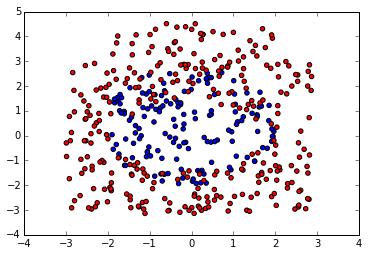

In [67]:
data=np.load("2d_data_elliptical.npy")
x=[i[0] for i in data]
y=[i[1] for i in data]
classifier=[i[2] for i in data]

plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()

In [ ]:
def logloss_function_exercise(parameter_1,parameter_2,parameter_3,x_feature,y_feature,label): #add as many parameters as you see fit
    logloss=0
    for i in range(len(x_feature)):
        if label[i]==1:
            logloss+=math.log(logit(parameter_1*(y_feature[i]- ("Try functions of x here")  )),10)
        else:
            logloss+=math.log(1-logit(parameter_1*(y_feature[i]- ("Put same function here")  )),10)
    return logloss

def logloss_function_exercise_wrapper(parameters):
    return -1*logloss_function_exercise(parameters[0],parameters[1],"etc, depends on how many parameters you've used",x,y,classifier)

#you'll need to initialise the minimisation search for as many parameters as you include in your model
minimisation_result=minimize(logloss_function_exercise_wrapper,[0,0,0]) 

print "The Optimised Steepness is",minimisation_result['x'][0]
print "The decision boundary parameter values are"
for i in range(1,len(minimisation_result['x'])):
    print minimisation_result['x'],i

x_coordinates=[float(i)/100 for i in range(100)]
decision_boundary=[ "your function of x_coordinates[i]" for i in range(len(x_coordinates)) ]


plt.figure()
plt.plot(x_coordinates,decision_boundary,c='k')
plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()